<a href="https://colab.research.google.com/github/Jun-Liu-291/Hands-On-Machine-Learning-with-Scikit-Learn-Keras-and-TensorFlow/blob/master/18_Reinforcement_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    !pip install -q -U tf-agents-nightly pyvirtualdisplay gym[atari]
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [1,781 kB]
G

# Learning to Optimize Rewards

a software agent makes observations and takes actions within an environment, and in return it receives rewards. learn to act in a way that will maximize its expected rewards over time.

# Policy Search

The algorithm a software agent uses to determine its actions is called its policy. The policy could be a neural network taking observations as inputs an outputnig the action to take.

# Introduction to OpenAI Gym

work environment.

In [2]:
import gym

In [3]:
# list all the available environments:
gym.envs.registry.all()

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSp

In [4]:
env = gym.make('CartPole-v1')

In [5]:
env.seed(42)
obs = env.reset() # initialize the environment

In [6]:
obs

array([-0.01258566, -0.00156614,  0.04207708, -0.00180545])

cart's horizontal position, velocity, the angle of the pole, and angular velocity.

In [7]:
gym.envs.registry.all()

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSp

In [8]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

In [9]:
env.render() # environment can be visualized by calling its render() mehod

True

In [10]:
img = env.render(mode="rgb_array")
img.shape

(400, 600, 3)

In [11]:
def plot_enviroment(env, figsize=(5, 2)):
  plt.figure(figsize=figsize)
  img = env.render(mode="rgb_array")
  plt.imshow(img)
  plt.axis("off")
  return img

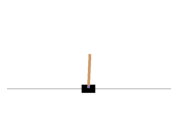

In [12]:
plot_enviroment(env)
plt.show()

In [13]:
# what this environment's action space looks like:
env.action_space

Discrete(2)

In [14]:
action = 1 # accelerate right
obs, reward, done, info = env.step(action)
obs

array([-0.01261699,  0.19292789,  0.04204097, -0.28092127])

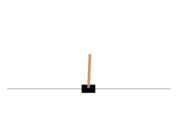

In [15]:
plot_enviroment(env)
plt.show()

In [16]:
reward

1.0

In [17]:
done # the game is over?

False

finally, ```info``` is an environment-specific dictionary that provide some extra information that you may find useful for debugging o for training. For example, in some games it may indicae how many lives the agent has.

In [18]:
info

{}

In [19]:
if done:
  obs = env.reset()

## Simple hard-coded policy

In [20]:
env.seed(42)

def basic_policy(obs):
  angle = obs[2]
  return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [21]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(41.718, 8.858356280936096, 24.0, 68.0)

In [22]:
# visualize one episode:

env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
  img = env.render(mode="rgb_array")
  frames.append(img)
  action = basic_policy(obs)

  obs, reward, done, info = env.step(action)
  if done:
    break

In [45]:
def update_scene(num, frames, patch):
  patch.set_data(frames[num])
  return patch

def plot_animation(frames, repeat=False, interval=100):
  fig = plt.figure()
  patch = plt.imshow(frames[0])
  plt.axis('off')
  anim = animation.FuncAnimation(
      fig, update_scene, fargs=(frames, patch),
      frames=len(frames), repeat=repeat, interval=interval
  )
  plt.close()
  return anim

In [24]:
plot_animation(frames)

## Neural Network Policies

In [25]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

n_inputs = 4

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid")
])

In [26]:
def render_policy_net(model, n_max_steps=200, seed=42):
  frames = []
  env = gym.make("CartPole-v1")
  env.seed(seed)
  np.random.seed(seed)
  obs = env.reset()
  for step in range(n_max_steps):
    frames.append(env.render(mode="rgb_array"))
    left_proba = model.predict(obs.reshape(1, -1))
    action = int(np.random.rand() > left_proba)
    obs, reward, done, info = env.step(action)
    if done:
      break
  env.close()
  return frames

In [27]:
frames = render_policy_net(model)
plot_animation(frames)

In [28]:
n_environments = 50
n_iterations = 5000

envs = [gym.make("CartPole-v1") for _ in range(n_environments)]
for index, env in enumerate(envs):
  env.seed(index)
np.random.seed(42)
observations = [env.reset() for env in envs]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
  # if angle < 0, we want proba(left) =1., ir else proba(left) = 0.
  target_probas = np.array([([1.] if obs[2] < 0 else [0.])
                            for obs in observations])
  with tf.GradientTape() as tape:
    left_probas = model(np.array(observations))
    loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
  print("\rIteration: {}, loss:{:.3f}".format(iteration, loss.numpy()), end="")
  grads = tape.gradient(loss, model.trainable_variables)
  actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
  for env_index, env in enumerate(envs):
    obs, reward, done, info = env.step(actions[env_index][0])
    observations[env_index] = obs if not done else env.reset()
for env in envs:
  env.close()

Iteration: 4999, loss:0.660

In [29]:
frames = render_policy_net(model)
plot_animation(frames)

# Policy Gradients

In [30]:
def play_one_step(env, obs, model, loss_fn):
  with tf.GradientTape() as tape:
    left_proba = model(obs[np.newaxis])
    action = (tf.random.uniform([1, 1]) > left_proba)
    y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
    loss = tf.reduce_mean(loss_fn(y_target, left_proba))
  grads = tape.gradient(loss, model.trainable_variables)
  obs, reward, done, info = env.step(int(action[0, 0].numpy()))
  return obs, reward, done, grads

In [31]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
  all_rewards = []
  all_grads = []
  for episode in range(n_episodes):
    current_rewards = []
    current_grads = []
    obs = env.reset()
    for step in range(n_max_steps):
      obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
      current_rewards.append(reward)
      current_grads.append(grads)
      if done:
        break
    all_rewards.append(current_rewards)
    all_grads.append(current_grads)
  return all_rewards, all_grads


In [32]:
def discount_rewards(rewards, discount_rate):
  discounted = np.array(rewards)
  for step in range(len(rewards) - 2, -1, -1):
    discounted[step] += discounted[step+1]*discount_rate
  return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
  all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                            for rewards in all_rewards]
  flat_rewards = np.concatenate(all_discounted_rewards)
  reward_mean = flat_rewards.mean()
  reward_std = flat_rewards.std()
  return [(discounted_rewards - reward_mean) / reward_std 
          for discounted_rewards in all_discounted_rewards]

In [33]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22, -40, -50])

In [34]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [35]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

In [36]:
optimizer = keras.optimizers.Adam(lr=0.01)
loss_fn = keras.losses.binary_crossentropy

In [37]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [38]:
env = gym.make("CartPole-v1")
env.seed(42)

for iteration in range(n_iterations):
  all_rewards, all_grads = play_multiple_episodes(
      env, n_episodes_per_update, n_max_steps, model, loss_fn
  )
  total_rewards = sum(map(sum, all_rewards))
  print("\rIteration: {}, mean rewards: {:.1f}".format(
      iteration, total_rewards / n_episodes_per_update
  ), end="")
  all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                     discount_rate)
  all_mean_grads = []
  for var_index in range(len(model.trainable_variables)):
    mean_grads = tf.reduce_mean(
        [final_reward * all_grads[episode_index][step][var_index]
         for episode_index, final_rewards in enumerate(all_final_rewards)
         for step, final_reward in enumerate(final_rewards)], axis=0
    )
    all_mean_grads.append(mean_grads)
  optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

Iteration: 149, mean rewards: 190.2

In [39]:
frames = render_policy_net(model)
plot_animation(frames)

# Markov Chains

In [40]:
np.random.seed(42)

transition_probabilities = [ # shape = [s, s']
      [0.7, 0.2, 0.0, 0.1], # from s0 to s0 s1 s2 s3
      [0.0, 0.0, 0.9, 0.1],
      [0.0, 1.0, 0.0, 0.0],
      [0.0, 0.0, 0.0, 1.0]                            
]

n_max_steps = 50

def print_sequence():
  current_state = 0
  print("State:", end=" ")
  for step in range(n_max_steps):
    print(current_state, end=" ")
    if current_state == 3:
      break
    current_state = np.random.choice(range(4), p=transition_probabilities[current_state])
  else:
    print("...", end="")
  print()

for _ in range(10):
  print_sequence()

State: 0 0 3 
State: 0 1 2 1 2 1 2 1 2 1 3 
State: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
State: 0 3 
State: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
State: 0 1 3 
State: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 ...
State: 0 0 3 
State: 0 0 0 1 2 1 2 1 3 
State: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 


## Markov Decision Process

In [41]:
transition_probabilities = [ # shape=[s, a, s']
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None]]
rewards = [ # shape=[s, a, s']
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]
possible_actions = [[0, 1, 2], [0, 2], [1]]

In [42]:
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions

In [43]:
gamma = 0.90  # the discount factor

history1 = [] # Not shown in the book (for the figure below)
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev) # Not shown
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

history1 = np.array(history1) # Not shown

In [44]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [45]:
np.argmax(Q_values, axis=1)

array([0, 0, 1])

In [46]:
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions

In [47]:
gamma = 0.95  # the discount factor

for iteration in range(50):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

In [48]:
Q_values

array([[21.73304188, 20.63807938, 16.70138772],
       [ 0.95462106,        -inf,  1.01361207],
       [       -inf, 53.70728682,        -inf]])

In [49]:
np.argmax(Q_values, axis=1)

array([0, 2, 1])

# Q-Learning

In [50]:
def step(state, action):
  probas = transition_probabilities[state][action]
  next_state = np.random.choice([0, 1, 2], p=probas)
  reward = rewards[state][action][next_state]
  return next_state, reward

In [51]:
def exploration_policy(state):
  return np.random.choice(possible_actions[state])

In [52]:
np.random.seed(42)

Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
  Q_values[state][actions] = 0

alpha0 = 0.05 # initial learning rate
decay = 0.005 # learning rate decay
gamma = 0.90 # discount factor
state = 0 # initial state
history2 = []

for iteration in range(10000):
  history2.append(Q_values.copy())
  action = exploration_policy(state)
  next_state, reward = step(state,action)
  next_value = np.max(Q_values[next_state]) # greedy policy at the next step
  alpha = alpha0 / (1 + iteration * decay)
  Q_values[state, action] *= 1- alpha
  Q_values[state, action] += alpha * (reward + gamma * next_value)
  state = next_state

history2 = np.array(history2)

In [53]:
Q_values

array([[18.77621289, 17.2238872 , 13.74543343],
       [ 0.        ,        -inf, -8.00485647],
       [       -inf, 49.40208921,        -inf]])

In [54]:
np.argmax(Q_values, axis=1) # optimal action for each state

array([0, 0, 1])

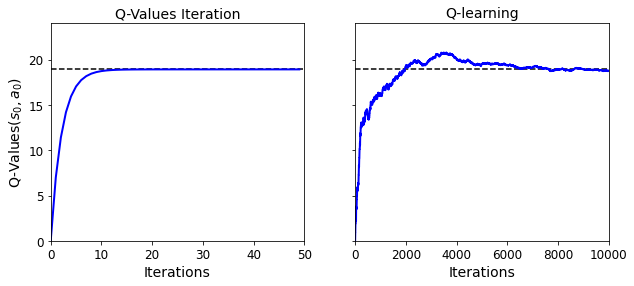

In [55]:
true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Values$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Values Iteration", fontsize=14)
axes[1].set_title("Q-learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
  ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
  ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
  ax.set_xlabel("Iterations", fontsize=14)
  ax.axis([0, width, 0, 24])



# Deep Q-Network

Given a state, it will estimate, for each possible action, the sum lf dicounted future rewards it can expect after it plays that action.

In [56]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

env = gym.make("CartPole-v1")
input_shape = [4]
n_outputs = 2

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

To select an action using this DQN, we just pick the action with the largest predicted Q-value. However, to ensure that the agent explores the environment, we choose a random action with probabiltiy `epsilon`.


In [57]:
def epsilon_greedy_policy(state, epsilon=0):
  if np.random.rand() < epsilon:
    return np.random.randint(2)
  else:
    Q_values = model.predict(state[np.newaxis])
    return np.argmax(Q_values[0])

We will also need a replay memory. It will contain the agent's experiences, in the form of tuples: `(obs, action, reward, next_obs, done)`. We can use the `deque` class for that:

In [58]:
from collections import deque

replay_memory = deque(maxlen=2000)

creat a function to sample experiences from the replay memory. It will return 5 Numpy arrays: `[obs, actions, rewards, next_obs, dones]`.

In [59]:
def sample_experiences(batch_size):
  indices = np.random.randint(len(replay_memory), size=batch_size)
  batch = [replay_memory[index] for index in indices]
  states, actions, rewards, next_states, dones = [
      np.array([experience[field_index] for experience in batch])
      for field_index in range(5)
  ]
  return states, actions, rewards, next_states, dones

create a function that will use the DQN to play one step, and record its experience in the replay memory:

In [60]:
def play_one_step(env, state, epsilon):
  action = epsilon_greedy_policy(state, epsilon)
  next_state, reward, done, info = env.step(action)
  replay_memory.append((state, action, reward, next_state, done))
  return next_state, reward, done, info

In [61]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
  experiences = sample_experiences(batch_size)
  states, actions, rewards, next_states, dones = experiences
  next_Q_values = model.predict(next_states)
  max_next_Q_values = np.max(next_Q_values, axis=1)
  target_Q_values = (rewards +
                     (1-dones) * discount_rate * max_next_Q_values)
  target_Q_values = target_Q_values.reshape(-1, 1)
  mask = tf.one_hot(actions, n_outputs)
  with tf.GradientTape() as tape:
    all_Q_values = model(states)
    Q_values = tf.reduce_sum(all_Q_values * mask, axis = 1, keepdims=True)
    loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [62]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = [] 
best_score = 0

In [63]:
for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step) 
    if step > best_score: 
        best_weights = model.get_weights() 
        best_score = step 
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

Episode: 599, Steps: 19, eps: 0.010

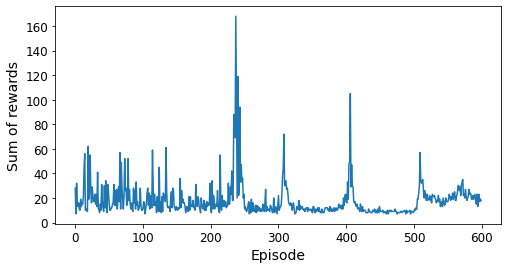

In [64]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

In [65]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

#  Double DQN

In [66]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=[4]),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [67]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [68]:
replay_memory = deque(maxlen=2000)

In [69]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step > best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode > 50:
        training_step(batch_size)
    if episode % 50 == 0:
        target.set_weights(model.get_weights())
    # Alternatively, you can do soft updates at each step:
    #if episode > 50:
        #target_weights = target.get_weights()
        #online_weights = model.get_weights()
        #for index in range(len(target_weights)):
        #    target_weights[index] = 0.99 * target_weights[index] + 0.01 * online_weights[index]
        #target.set_weights(target_weights)

model.set_weights(best_weights)

Episode: 599, Steps: 49, eps: 0.010

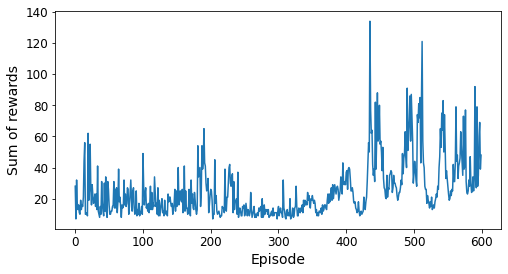

In [70]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

In [71]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

# Dueling DQN

In [72]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
input_states = keras.layers.Input(shape=[4])
hidden1 = keras.layers.Dense(32, activation="elu")(input_states)
hidden2 = keras.layers.Dense(32, activation="elu")(hidden1)
state_values = keras.layers.Dense(1)(hidden2)
raw_advantages = keras.layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)
Q_values = state_values + advantages
model = keras.models.Model(inputs=[input_states], outputs=[Q_values])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [73]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(lr=1e-2)
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [74]:
replay_memory = deque(maxlen=2000)

In [75]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step > best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode > 50:
        training_step(batch_size)
    if episode % 200 == 0:
        target.set_weights(model.get_weights())

model.set_weights(best_weights)

Episode: 599, Steps: 74, eps: 0.010

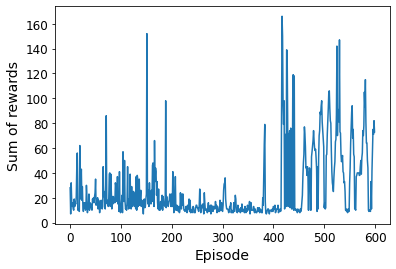

In [76]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.show()

In [77]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

In [78]:
env.close()

# The TF-Agents Library



## Installing TF-Agents

In [5]:
tf.random.set_seed(42)
np.random.seed(42)

In [6]:
from tf_agents.environments import suite_gym

env = suite_gym.load("Breakout-v4")
env

In [7]:
env.gym

In [8]:
env.seed(42)
env.reset()

TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

In [9]:
env.step(np.array(1)) # 1

TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

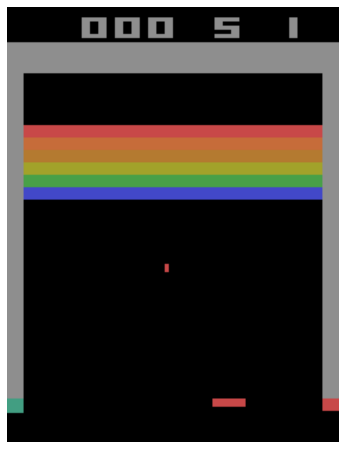

In [10]:
img = env.render(mode="rgb_array")

plt.figure(figsize=(6, 8))
plt.imshow(img)
plt.axis("off")
plt.show()

In [11]:
env.current_time_step()

TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

## Environment Specifications

In [12]:
env.observation_spec()

BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)

In [13]:
env.action_spec()

BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)

In [14]:
env.time_step_spec()

TimeStep(step_type=ArraySpec(shape=(), dtype=dtype('int32'), name='step_type'), reward=ArraySpec(shape=(), dtype=dtype('float32'), name='reward'), discount=BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0), observation=BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255))

In [15]:
env.gym.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

## Environment Wrappers

In [16]:
from tf_agents.environments.wrappers import ActionRepeat

repeating_env = ActionRepeat(env, times=4)
repeating_env

In [17]:
repeating_env.unwrapped

In [18]:
import tf_agents.environments.wrappers

for name in dir(tf_agents.environments.wrappers):
    obj = getattr(tf_agents.environments.wrappers, name)
    if hasattr(obj, "__base__") and issubclass(obj, tf_agents.environments.wrappers.PyEnvironmentBaseWrapper):
        print("{:27s} {}".format(name, obj.__doc__.split("\n")[0]))

ActionClipWrapper           Wraps an environment and clips actions to spec before applying.
ActionDiscretizeWrapper     Wraps an environment with continuous actions and discretizes them.
ActionOffsetWrapper         Offsets actions to be zero-based.
ActionRepeat                Repeates actions over n-steps while acummulating the received reward.
FlattenObservationsWrapper  Wraps an environment and flattens nested multi-dimensional observations.
GoalReplayEnvWrapper        Adds a goal to the observation, used for HER (Hindsight Experience Replay).
HistoryWrapper              Adds observation and action history to the environment's observations.
ObservationFilterWrapper    Filters observations based on an array of indexes.
OneHotActionWrapper         Converts discrete action to one_hot format.
PerformanceProfiler         End episodes after specified number of steps.
PyEnvironmentBaseWrapper    PyEnvironment wrapper forwards calls to the given environment.
RunStats                    Wrapp

In [19]:
from functools import partial
from gym.wrappers import TimeLimit

limited_repeating_env = suite_gym.load(
    "Breakout-v4",
    gym_env_wrappers=[partial(TimeLimit, max_episode_steps=10000)],
    env_wrappers=[partial(ActionRepeat, times=4)],
)

In [20]:
limited_repeating_env

In [21]:
limited_repeating_env.unwrapped

In [22]:
from tf_agents.environments import suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

max_episode_steps = 27000
environment_name = "BreakoutNoFrameskip-v4"

env = suite_atari.load(
    environment_name,
    max_episode_steps=max_episode_steps,
    gym_env_wrappers=[AtariPreprocessing, FrameStack4]
)

In [23]:
env

In [24]:
env.seed(42)
env.reset()
time_step = env.step(np.array(1)) # FIRE
for _ in range(4):
  time_step = env.step(np.array(3)) # left

In [25]:
def plot_observation(obs):
  obs = obs.astype(np.float32)
  img = obs[..., :3]
  current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1), 0.)
  img[..., 0] += current_frame_delta
  img[..., 2] += current_frame_delta
  img = np.clip(img / 150, 0, 1)
  plt.imshow(img)
  plt.axis("off")

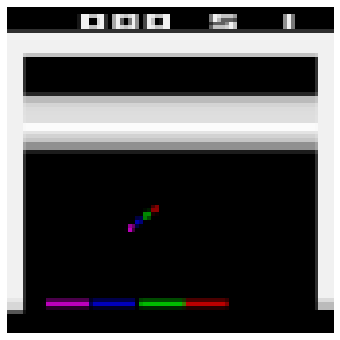

In [26]:
plt.figure(figsize=(6, 6))
plot_observation(time_step.observation)
plt.show()

In [27]:
# convert the python environment to a TF environment
from tf_agents.environments.tf_py_environment import TFPyEnvironment

tf_env = TFPyEnvironment(env)

## Creating the DQN

In [28]:
from tf_agents.networks.q_network import QNetwork

preprocessing_layer = keras.layers.Lambda(
    lambda obs: tf.cast(obs, np.float32) / 255.
)
conv_layer_params = [(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params=[512]

q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params
)

Create the DQN Agent

In [29]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent

train_step = tf.Variable(0)
update_period = 4
optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate=2.5e-4, decay=0.95, momentum=0.0,
                                                epsilon=0.00001, centered=True)
epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0,
    decay_steps=250000 // update_period,
    end_learning_rate=0.01
)
agent = DqnAgent(tf_env.time_step_spec(),
                 tf_env.action_spec(),
                 q_network=q_net,
                 optimizer=optimizer,
                 target_update_period=2000,
                 td_errors_loss_fn=keras.losses.Huber(reduction="none"),
                 gamma=0.99,
                 train_step_counter=train_step,
                 epsilon_greedy=lambda: epsilon_fn(train_step))
agent.initialize()

Create the replay buffer:

In [31]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=100000
)

replay_buffer_observer = replay_buffer.add_batch

Create a simple custom observer that counts and displays the number of times it is called (except when it is passed a trajectory that represents the boundary between two episodes, as this does not count as a step):

In [32]:
class ShowProgress:
  def __init__(self, total):
    self.counter = 0
    self.total = total
  def __call__(self, trajectory):
    if not trajectory.is_boundary():
      self.counter += 1
    if self.counter % 100 == 0:
      print("\r{}/{}".format(self.counter, self.total), end="")

In [33]:
# add training metrics
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

In [34]:
train_metrics[0].result()

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [35]:
from tf_agents.eval.metric_utils import log_metrics
import logging

logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


In [36]:
# Create the collect driver:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period
)

In [37]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(),
                                        tf_env.action_spec())
init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=20000) # <=> 80,000 ALE frames
final_time_step, final_policy_state = init_driver.run()

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


20000/20000

In [38]:
tf.random.set_seed(888) # chosen to show an example of trajectory at the end of an episode

trajectories, buffer_info = replay_buffer.get_next(
    sample_batch_size=2, num_steps=3)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [39]:
trajectories._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [40]:
trajectories.observation.shape

TensorShape([2, 3, 84, 84, 4])

In [41]:
from tf_agents.trajectories.trajectory import to_transition

time_steps, action_steps, next_time_steps = to_transition(trajectories)
time_steps.observation.shape

TensorShape([2, 2, 84, 84, 4])

In [42]:
trajectories.step_type.numpy()

array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)

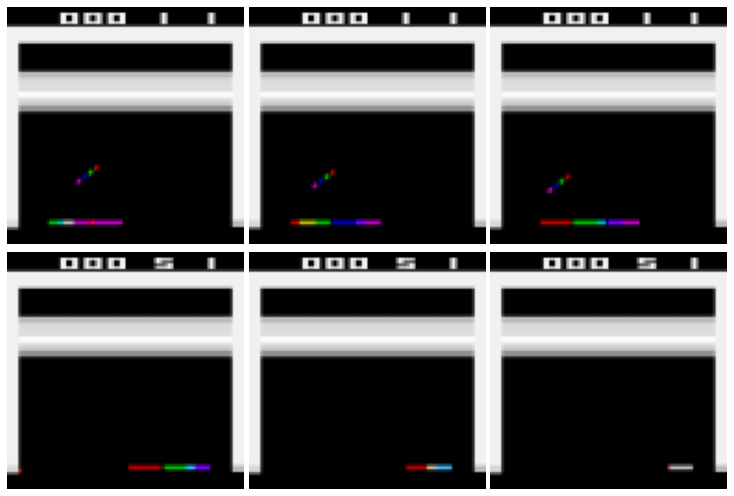

In [44]:
plt.figure(figsize=(10, 6.8))
for row in range(2):
    for col in range(3):
        plt.subplot(2, 3, row * 3 + col + 1)
        plot_observation(trajectories.observation[row, col].numpy())
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0.02)
plt.show()

In [46]:
dataset = replay_buffer.as_dataset(
    sample_batch_size=64,
    num_steps=2,
    num_parallel_calls=3).prefetch(3)

In [47]:
from tf_agents.utils.common import function

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

In [48]:
def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        print("\r{} loss:{:.5f}".format(
            iteration, train_loss.loss.numpy()), end="")
        if iteration % 1000 == 0:
            log_metrics(train_metrics)

In [49]:
train_agent(n_iterations=10000)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 4
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


999 loss:0.00014

INFO:absl: 
		 NumberOfEpisodes = 23
		 EnvironmentSteps = 4004
		 AverageReturn = 1.0
		 AverageEpisodeLength = 174.89999389648438


1998 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 48
		 EnvironmentSteps = 8004
		 AverageReturn = 0.5
		 AverageEpisodeLength = 152.39999389648438


2999 loss:0.00009

INFO:absl: 
		 NumberOfEpisodes = 73
		 EnvironmentSteps = 12004
		 AverageReturn = 0.5
		 AverageEpisodeLength = 153.8000030517578


3998 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 97
		 EnvironmentSteps = 16004
		 AverageReturn = 0.699999988079071
		 AverageEpisodeLength = 164.0


4999 loss:0.00012

INFO:absl: 
		 NumberOfEpisodes = 120
		 EnvironmentSteps = 20004
		 AverageReturn = 1.0
		 AverageEpisodeLength = 172.39999389648438


5998 loss:0.00769

INFO:absl: 
		 NumberOfEpisodes = 143
		 EnvironmentSteps = 24004
		 AverageReturn = 1.5
		 AverageEpisodeLength = 193.89999389648438


6998 loss:0.00005

INFO:absl: 
		 NumberOfEpisodes = 166
		 EnvironmentSteps = 28004
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 173.1999969482422


7999 loss:0.00005

INFO:absl: 
		 NumberOfEpisodes = 189
		 EnvironmentSteps = 32004
		 AverageReturn = 1.0
		 AverageEpisodeLength = 176.10000610351562


8999 loss:0.00760

INFO:absl: 
		 NumberOfEpisodes = 211
		 EnvironmentSteps = 36004
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 175.60000610351562


9999 loss:0.00003

In [50]:
frames = []
def save_frames(trajectory):
    global frames
    frames.append(tf_env.pyenv.envs[0].render(mode="rgb_array"))

prev_lives = tf_env.pyenv.envs[0].ale.lives()
def reset_and_fire_on_life_lost(trajectory):
    global prev_lives
    lives = tf_env.pyenv.envs[0].ale.lives()
    if prev_lives != lives:
        tf_env.reset()
        tf_env.pyenv.envs[0].step(np.array(1))
        prev_lives = lives

watch_driver = DynamicStepDriver(
    tf_env,
    agent.policy,
    observers=[save_frames, reset_and_fire_on_life_lost, ShowProgress(1000)],
    num_steps=1000)
final_time_step, final_policy_state = watch_driver.run()

plot_animation(frames)

900/1000

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


1000/1000

In [51]:
import PIL

image_path = os.path.join("images", "rl", "breakout.gif")
frame_images = [PIL.Image.fromarray(frame) for frame in frames[:150]]
frame_images[0].save(image_path, format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=30,
                     loop=0)